In [71]:
%matplotlib inline
%config InlineBackend.figure_format='svg'
#%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.stats import LombScargle

from scipy import integrate
import astropy
from astropy.time import Time

import pyfits
%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [3]:
from cycler import cycler

In [72]:
import gatspy.periodic
#from gatspy.periodic import LombScargle 
#from gatspy.periodic import LombScargleFast
from astroML.datasets import fetch_LINEAR_sample,fetch_LIGO_bigdog,fetch_LIGO_large,fetch_nasa_atlas

In [62]:
marker=['.','v','^','<','>','1','2','3','4','8','s','p','P','*','h','H','+','x','X','D','d','|','_']
color=['red','sandybrown','tan','gold','olivedrab','chartreuse','darkgreen','blue','m','skyblue','violet','crimson','aqua','purple','magenta','yellow','lime','turquoise','lightcyan','teal','lightblue','indigo']


In [64]:
len(marker),len(color)

(23, 22)

In [67]:
len(t)

1000

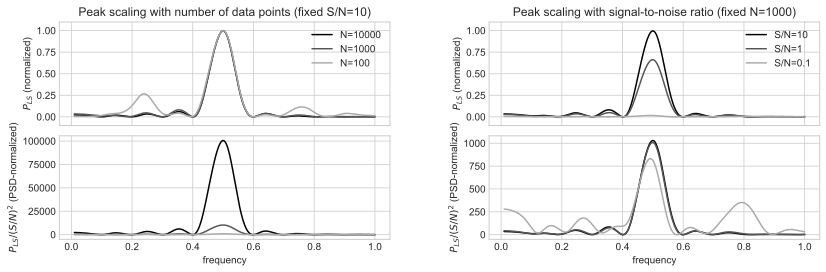

In [65]:
def create_data(N, T=10, signal_to_noise=5, period=2.0, random_state=None):
    rng = np.random.RandomState(random_state)
    t = T * rng.rand(N)#均匀分布
    dy = 0.5 / signal_to_noise * np.ones_like(t)
    y = np.sin(2 * np.pi * t / period) + dy * rng.randn(N)
    return t, y, dy


fig, ax = plt.subplots(2, 2, figsize=(12, 4), sharex='col')
fig.subplots_adjust(hspace=0.1, wspace=0.3, left=0.07, right=0.95)

for axi in ax.flat:
    axi.set_prop_cycle(cycler('color', ['#000000', '#555555', '#AAAAAA']))

SN = 10
for N in [10000, 1000, 100]:
    t, y, dy = create_data(N, signal_to_noise=SN, random_state=68345)
    ls = LombScargle(t, y, dy)
    freq = np.linspace(0.01, 1, 2000)
    power = ls.power(freq, normalization='standard', assume_regular_frequency=True)
    ax[0, 0].plot(freq, power, label='N={0}'.format(N))
    power = ls.power(freq, normalization='psd', assume_regular_frequency=True)
    ax[1, 0].plot(freq, power / SN, label='N={0}'.format(N))
ax[0, 0].legend()

N = 1000
for SN in [10, 1, 0.1]:
    t, y, dy = create_data(N, signal_to_noise=SN, random_state=68345)
    ls = LombScargle(t, y, dy)
    freq = np.linspace(0.01, 1, 2000)
    power = ls.power(freq, normalization='standard', assume_regular_frequency=True)
    ax[0, 1].plot(freq, power, label='S/N={0}'.format(SN))
    power = ls.power(freq, normalization='psd', assume_regular_frequency=True)
    ax[1, 1].plot(freq, power / SN ** 2, label='S/N={0}'.format(SN))
ax[0, 1].legend()

ax[0, 0].set(ylim=(-0.1, 1.1),
             ylabel='$P_{LS}$ (normalized)',
             title='Peak scaling with number of data points (fixed S/N=10)')
ax[0, 1].set(ylim=(-0.1, 1.1),
             ylabel='$P_{LS}$ (normalized)',
             title='Peak scaling with signal-to-noise ratio (fixed N=1000)')


ax[1, 0].set(xlabel='frequency',
             ylabel='$P_{LS} / (S/N)^2$ (PSD-normalized)')
ax[1, 1].set(xlabel='frequency',
             ylabel='$P_{LS} / (S/N)^2$ (PSD-normalized)')

fig.savefig('/Users/brettlv/blog/IHEP_sync/file_to_mac/data/fig_peak_width_height.pdf')

In [56]:
def LombScargle_bootstrap(t, y, dy, freq, n_bootstraps=100,
                          aggregate=max, random_seed=None,
                          normalization='standard'):
    rng = np.random.RandomState(random_seed)
    
    def bootstrapped_power():
        resample = rng.randint(0, len(y), len(y))  # sample with replacement
        ls_boot = LombScargle(t, y[resample], dy[resample])
        return aggregate(ls_boot.power(freq, normalization=normalization))
    
    return np.array([bootstrapped_power() for i in range(n_bootstraps)])

/Users/brettlv/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


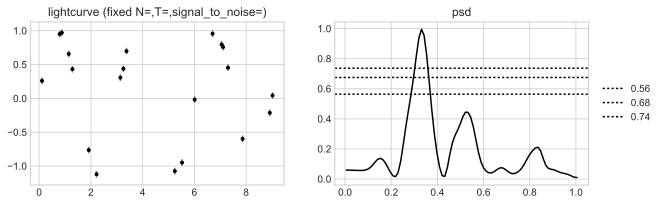

In [89]:
t, y, dy = create_data(20,T=10,period=3.0, signal_to_noise=10, random_state=583)
ls = LombScargle(t, y, dy)
freq, power = ls.autopower(maximum_frequency=1.0, samples_per_peak=10)

p_boot = LombScargle_bootstrap(t, y, dy, freq)

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].errorbar(t, y, dy, fmt='.k', ecolor='gray', capsize=0)
ax[0].set(title='lightcurve (fixed N=,T=,signal_to_noise=)')
ax[1].set(title='psd')

ax[1].plot(freq, power, '-k')

for cutoff in np.percentile(p_boot, [95,99,99.99]):
    ax[1].axhline(cutoff, color='black', linestyle='dotted',label="{:.2f}".format(cutoff))
    
ax[0].legend() 
ax[1].legend(loc='center', bbox_to_anchor=(1.15, 0.5)) 

fig.savefig('/Users/brettlv/blog/IHEP_sync/file_to_mac/data/fig_peak_uncertainty.pdf')    

/Users/brettlv/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


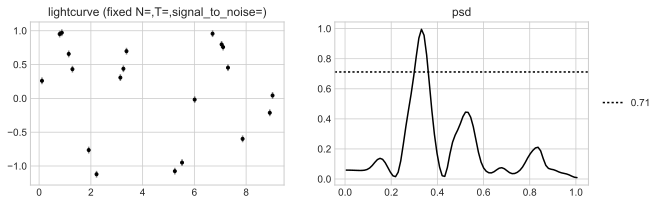

In [90]:
t, y, dy = create_data(20,T=10,period=3.0, signal_to_noise=10, random_state=583)
ls = LombScargle(t, y, dy)
freq, power = ls.autopower(maximum_frequency=1.0, samples_per_peak=10)

p_boot = LombScargle_bootstrap(t, y, dy, freq)

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].errorbar(t, y, dy, fmt='.k', ecolor='gray', capsize=0)
ax[0].set(title='lightcurve (fixed N=,T=,signal_to_noise=)')
ax[1].set(title='psd')

ax[1].plot(freq, power, '-k')

for cutoff in np.percentile(p_boot, [99]):
    ax[1].axhline(cutoff, color='black', linestyle='dotted',label="{:.2f}".format(cutoff))
    
ax[0].legend() 
ax[1].legend(loc='center', bbox_to_anchor=(1.15, 0.5)) 

fig.savefig('/Users/brettlv/blog/IHEP_sync/file_to_mac/data/fig_peak_uncertainty.pdf')    